In [24]:
#General Imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import statistics
from collections import Counter
#EDA Imports
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.metrics import recall_score, precision_score, f1_score

#Model build Imports
from sklearn.cluster import DBSCAN

# Hate Speech Detection

I want to build an algorithim to  categorize tweets.  This will use the Hate Speach and Offensive Language dataset at [https://www.kaggle.com/datasets/mrmorj/hate\-speech\-and\-offensive\-language\-dataset?select=labeled\_data.csv](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?select=labeled_data.csv).  This dataset is 24782 tweets long with users voting on if the tweet is offensive 0, hate speach 1 or neither 2, with the winning label being selected as a class.  

## Goal

My goal is to identify groupings of tweets based on topic.  With 27k+  tweets, I should be able to find 30-50 groups based on topics.

## Approach

I am planning to use a combination of TF-IDF, matrix factorization, and clustering algorithims to tweets by 1 and 2 word clusters.  I will then create similarity tables and use rainbow clustering to find groups of tweets.

### Disclaimer

This assignment necessary contains hate speach, and offensive langauge.  This does not represent the views of the author.

## Import and Cleaning

### Import

This data imports fairly easily.  I donloaded a copy of the file from kaggle and mirrored it to my GitHub so I could autodownload it for your use.

### Data Description

The data concists of 24782 tweets which have been user labeled as either hate, offensive, or neither, along with a total cont of votes.

In [25]:
#Initial Import
raw_data = pd.read_csv('Data/labeled_data.csv', header = 0)
print(raw_data)
raw_data = raw_data.drop(columns = 'Unnamed: 0')



       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24778       25291      3            0                   2        1      1   
24779       25292      3            0                   1        2      2   
24780       25294      3            0                   3        0      1   
24781       25295      6            0                   6        0      1   
24782       25296      3            0                   0        3      2   

                                                   tweet  
0      !!! RT @m

Text(0.5, 1.0, 'Top 30 Most Common Words')

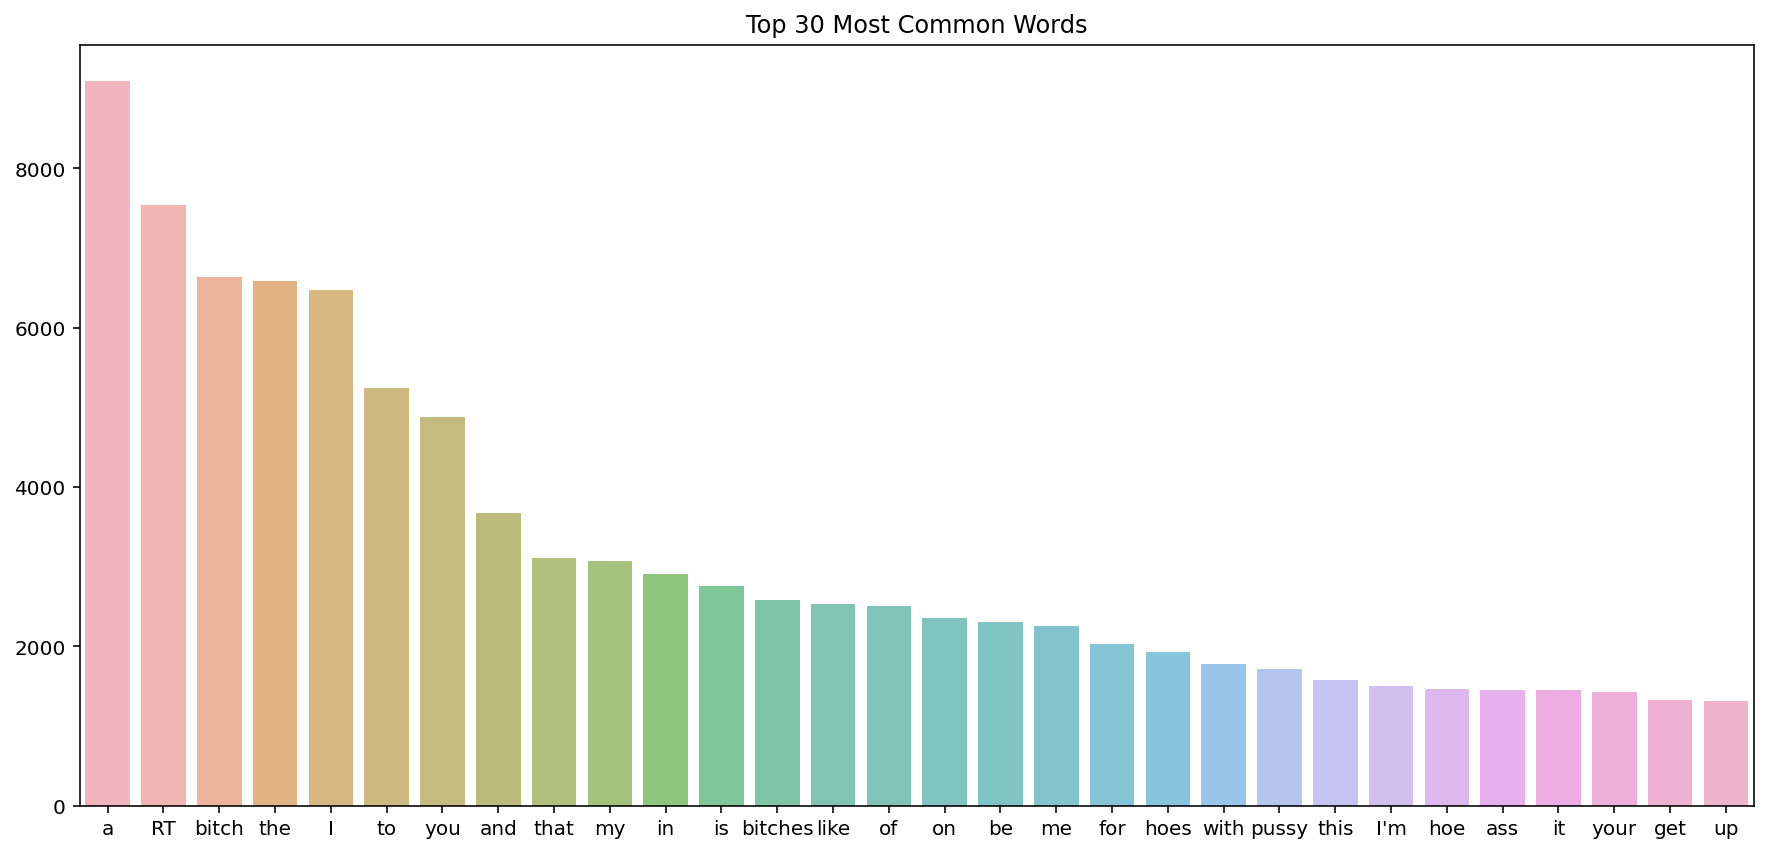

In [26]:
bad_words = (Counter(" ".join(raw_data['tweet']).split()).most_common(30))
bad_words = list(zip(*bad_words))
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x = list(bad_words[0]), y = list(bad_words[1]), ax=ax, alpha = .7).set_title("Top 30 Most Common Words")

### Cleaning

#### **Tweets with newline**

There appears to be a mismatch between the number of lines generated and the number of lines imported.  This is caused by newline characters, commas, quotation marks, and other supidity mixed in.  I chose to build my own parser to deal with all the issues and allow me to deal with the various problems with the data.\
**Update**\
There are skipped tweet numbers with no indicator in the dataset other than looking.

##### **Some examples of problematic formating.**

22422,3,0,3,0,1,"This bitch fell straight through the chair... Im high, of course I laughed..\
\
\
\
Even if I wasn't I would've still laughed."

256,3,0,3,0,1,"""@TheNewSAT: #NewSATQuestions\
Yeah bitch, yeah bitch, call me _______:\
a.) Maybe\
b.) Steve-O\
c.) Later\
d.) Jesse Pinkman""\
@machinegunkelly"

#### **Username Cleanup**

I chose to just drop all usernames.  This is due to usernames being random characters and it's out of scope for this project to try to do abusive username detection.

#### **Unicode Characters, numbers, and non-text characters**

I also chose to drop all unicode characters (Doing this save soo much time), numbers and most non-text characters.  The exception was the "*" character.  The * character is used to mask offensive words and when used, the resulting word length is fairly standard.

#### ReTweets
I chose to remove the retweet "RT" from the dataset.  This may be able to be used as a category for other analasys but is not needed in this research.




In [27]:
def text_cleanup(text):
    #Remove usernames replace @xxx: with whitespace
    text = re.sub(r"@.*?:", " ", text)
    #remove unicode characters
    text = re.sub(r"&#[0-9]{1,6};", " ", text)
    #lowercase all text
    text = text.lower()
    #remove URL's
    text = re.sub(r'http[s]?:\/\/.*?"', " ", text)
    #remove special characters and numberrs'
    #I chose to leave in *'s as they are a common manipulation to get around filters
    text = re.sub(r"[^a-z\*]", " ", text)
    #remove "RT"
    text = re.sub(r"\bRT\b", "", text)
    text = re.sub(r"rt\b", "", text)
    #remove lone T and S
    text = re.sub(r"\b(t|s|m)\b", "", text)
    #Remove Residual HTTP
    text = re.sub(r"\b(http[s]?|co[m]?)\b", "", text)
    #remove repeat whitespace and newlines
    text = re.sub(r"\s\s+", " ", text)
    text = re.sub(r"\n+", "", text)
    return text
    

raw_data["tweet"] = raw_data["tweet"].apply(text_cleanup)
print(raw_data['tweet'])


0         as a woman you shouldn complain about cleanin...
1         boy dats cold tyga dwn bad for cuffin dat hoe...
2         you ever fuck a bitch and she sta to cry you ...
3                        viva based she look like a tranny
4         the shit you hear about me might be true or i...
                               ...                        
24778    you a muthaf***in lie pearls corey emanuel rig...
24779    you ve gone and broke the wrong hea baby and d...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782     ruffled ntac eileen dahlia beautiful color co...
Name: tweet, Length: 24783, dtype: object


# EDA

### Basic Characteristics

The average character count of the uncleaned tweets is 85.  The average word count is 14.  
Number of words in each class: 1: Offensive Language 19190, 2: None 4163, 0: Hate Speech 1430.  This skew means that 1 category accounts for 70% of tweets and will heavily skew any classification attempts.


Mean Charater Count: 68.39184118145504
Mean Word Count: 14.294637453092847
Basic Data CharasiticsCounter({1: 19190, 2: 4163, 0: 1430})
30 Most common words.
68.39184118145504


Text(0.5, 1.0, 'Top 30 Most Common Words')

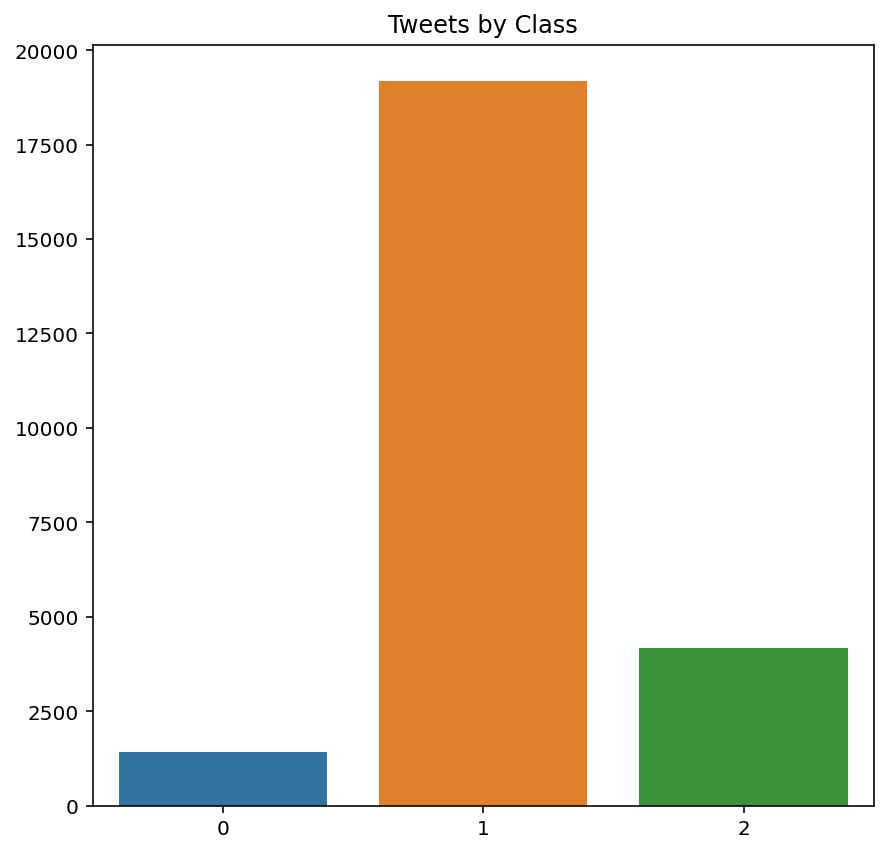

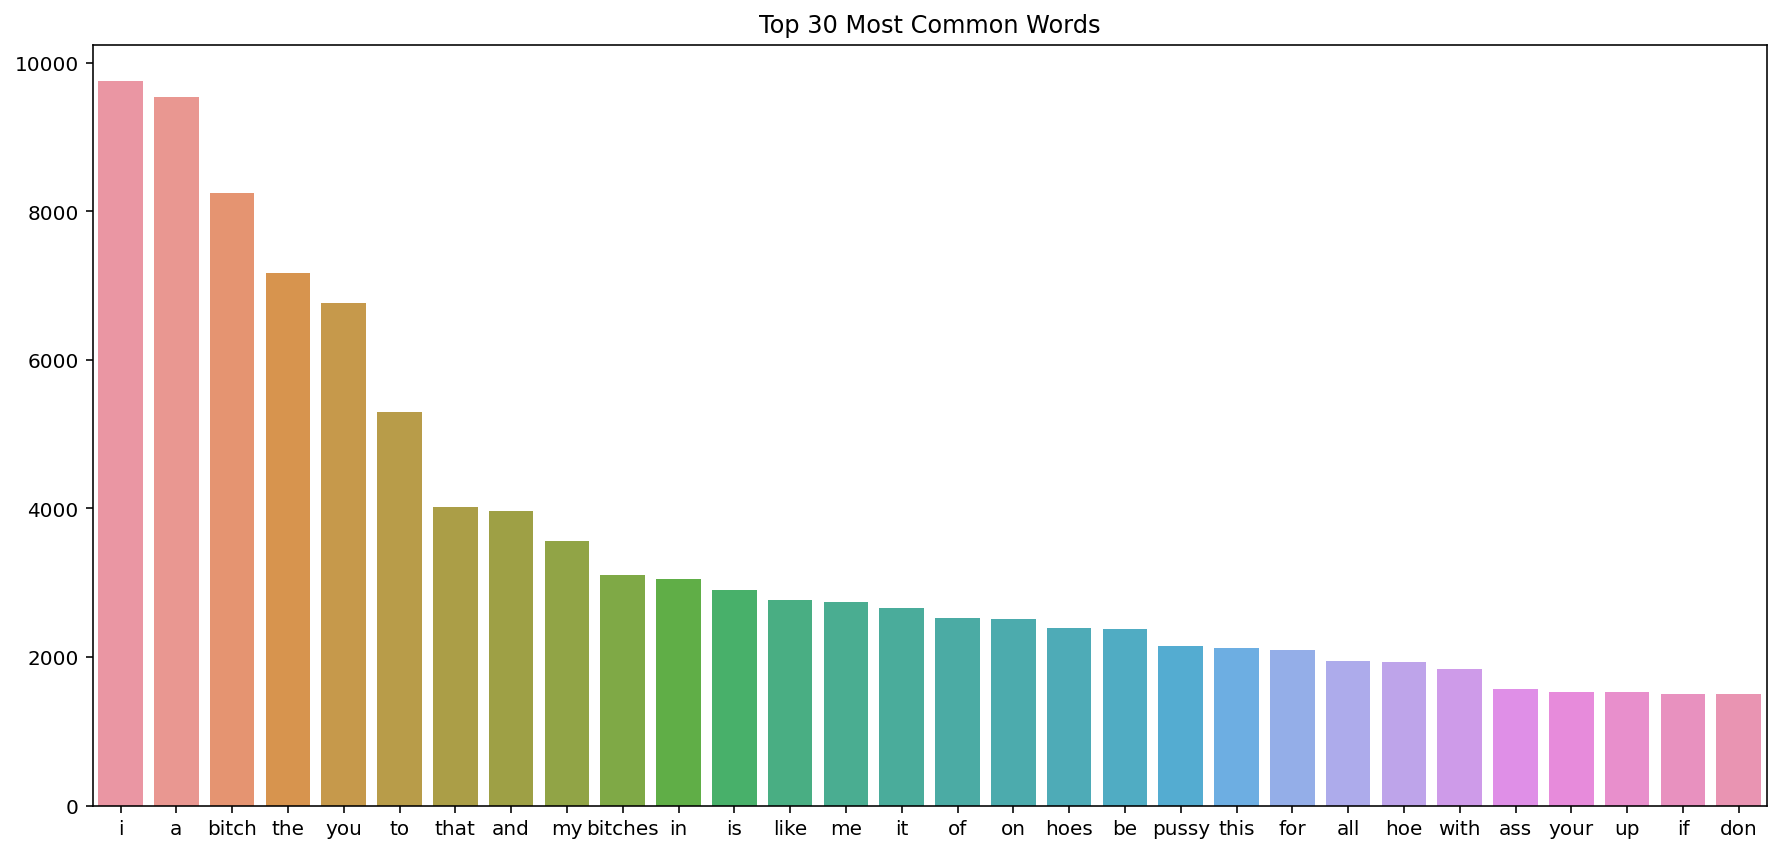

In [28]:
print("Mean Charater Count: " + str(statistics.mean(raw_data['tweet'].str.len())))
print("Mean Word Count: " + str(np.mean(raw_data['tweet'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))))
print("Basic Data Charasitics" + str(Counter(raw_data['class'])))
print("30 Most common words.")
bad_words = (Counter(" ".join(raw_data['tweet']).split()).most_common(30))
bad_words = list(zip(*bad_words))
print(statistics.mean(raw_data['tweet'].str.len()))
fig, ax = plt.subplots(figsize=(7, 7))
keys = list(Counter(raw_data['class']).keys())
vals = [Counter(raw_data['class'])[k] for k in keys]
sns.barplot(x=keys, y=vals, ax=ax).set_title("Tweets by Class")
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x = list(bad_words[0]), y = list(bad_words[1]), ax=ax).set_title("Top 30 Most Common Words")

## EDA Procedure

### Basic Data Charaistics After Cleanup

A tweet at the time of this data being collected can contain at maxiumum 280 Characters.  

### Formatting Data

I will start with dropping all the non-tweet columns.  This will be blind learning.

### Bagging

I chose to use TF\-IDF for my bagging procedure.  I am testing using unigrams single words only.  I may retest this using bigrams later., and am removing common English stopwords.  I decided not to restrict common words as the most common words are 27%.  I may experiment with this later.  

Exploratory analays was done on unigrams and bigrams.  

### DBSCAN

DBSCAN or Density\-Based Spatial Clustering of Applications with Noise is a clustering algorithm that uses the density of datapoints to classify objects.  In this case, I'm using DBSCAN to provide coloring of my graphed results.  Although I will use it later for actual model building, I am using it here to provide color differences.


That's not good.  All of the data seems to be in 1 large clump.  That will not do for classification.  I can try to get rid of the outliers, or I can try to clean the data.  I will try both. 

## Attempt to get rid of highly common elements.

In this I will rerun the TF\-IDF with a maximum document frequency of .2 and .15 and see if I get a better spread.  This change reduced the spacing between the 2 sets of elements.  



In [31]:
def TF_IDF(tweets, ngram_range, max_df):
    tfidf = TfidfVectorizer(input='content', encoding='utf-8', \
                            decode_error='strict', strip_accents='ascii', \
                            lowercase=True, preprocessor=None, tokenizer=None, \
                            analyzer='word', stop_words='english',  \
                            ngram_range=(ngram_range, ngram_range),max_df = max_df, max_features=None,\
                            vocabulary=None, binary=False, norm='l2', \
                            use_idf=True, smooth_idf=True, sublinear_tf=False)
    tfidf = tfidf.fit(raw_data['tweet'])
    tfidf_data = tfidf.transform(raw_data['tweet'])
    feature_names = tfidf.get_feature_names_out()
    return (tfidf_data, feature_names)

def TSNE_Process(tfidf_data, gram_size, k_val):
    tsne_results = TSNE(n_components=2, learning_rate='auto'\
                                 ,init='random', perplexity=30, n_iter = 600\
                                ).fit_transform(tfidf_data)
    tsne_results = pd.DataFrame(tsne_results, columns = ['x', 'y'])
    tsne_results['gram_size'] = gram_size
    tsne_results['k'] = k_val
    #print(tsne_results)
    return tsne_results

def build_model(tsne_results):
    #print(tsne_results.shape)
    dbscan = DBSCAN(eps=2.0, min_samples=100,\
                    metric='euclidean', metric_params=None, \
                    algorithm='auto', leaf_size=30, p=None, \
                    n_jobs=None)

    tsne_results['predict'] = dbscan.fit_predict(tsne_results.drop(columns = ['gram_size', 'k']), tsne_results.drop(columns = ['gram_size', 'k']))
    tsne_results['predict'] = tsne_results['predict'].where(tsne_results['predict'] == 0, 1)
    #print(model_data['predict'].value_counts())
    #print(tsne_results)
    return tsne_results
def assign_clusters():
    return 0

In [32]:
model_data = pd.DataFrame()
model_size = {'Unigram':1, 'Bigram':2}
k_values = [1,0.15]
for ms in model_size:
    for k_val in k_values:
        #print (ms)
        #print(model_size[ms])
        #print(k_val)
        
        TF_IDF_output, features_output = TF_IDF(raw_data['tweet'],model_size[ms] , k_val)
        TSNE_output = TSNE_Process(TF_IDF_output, ms, k_val)
        model_data = pd.concat([build_model(TSNE_output), model_data], axis = 0)
        #print(model_data)


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


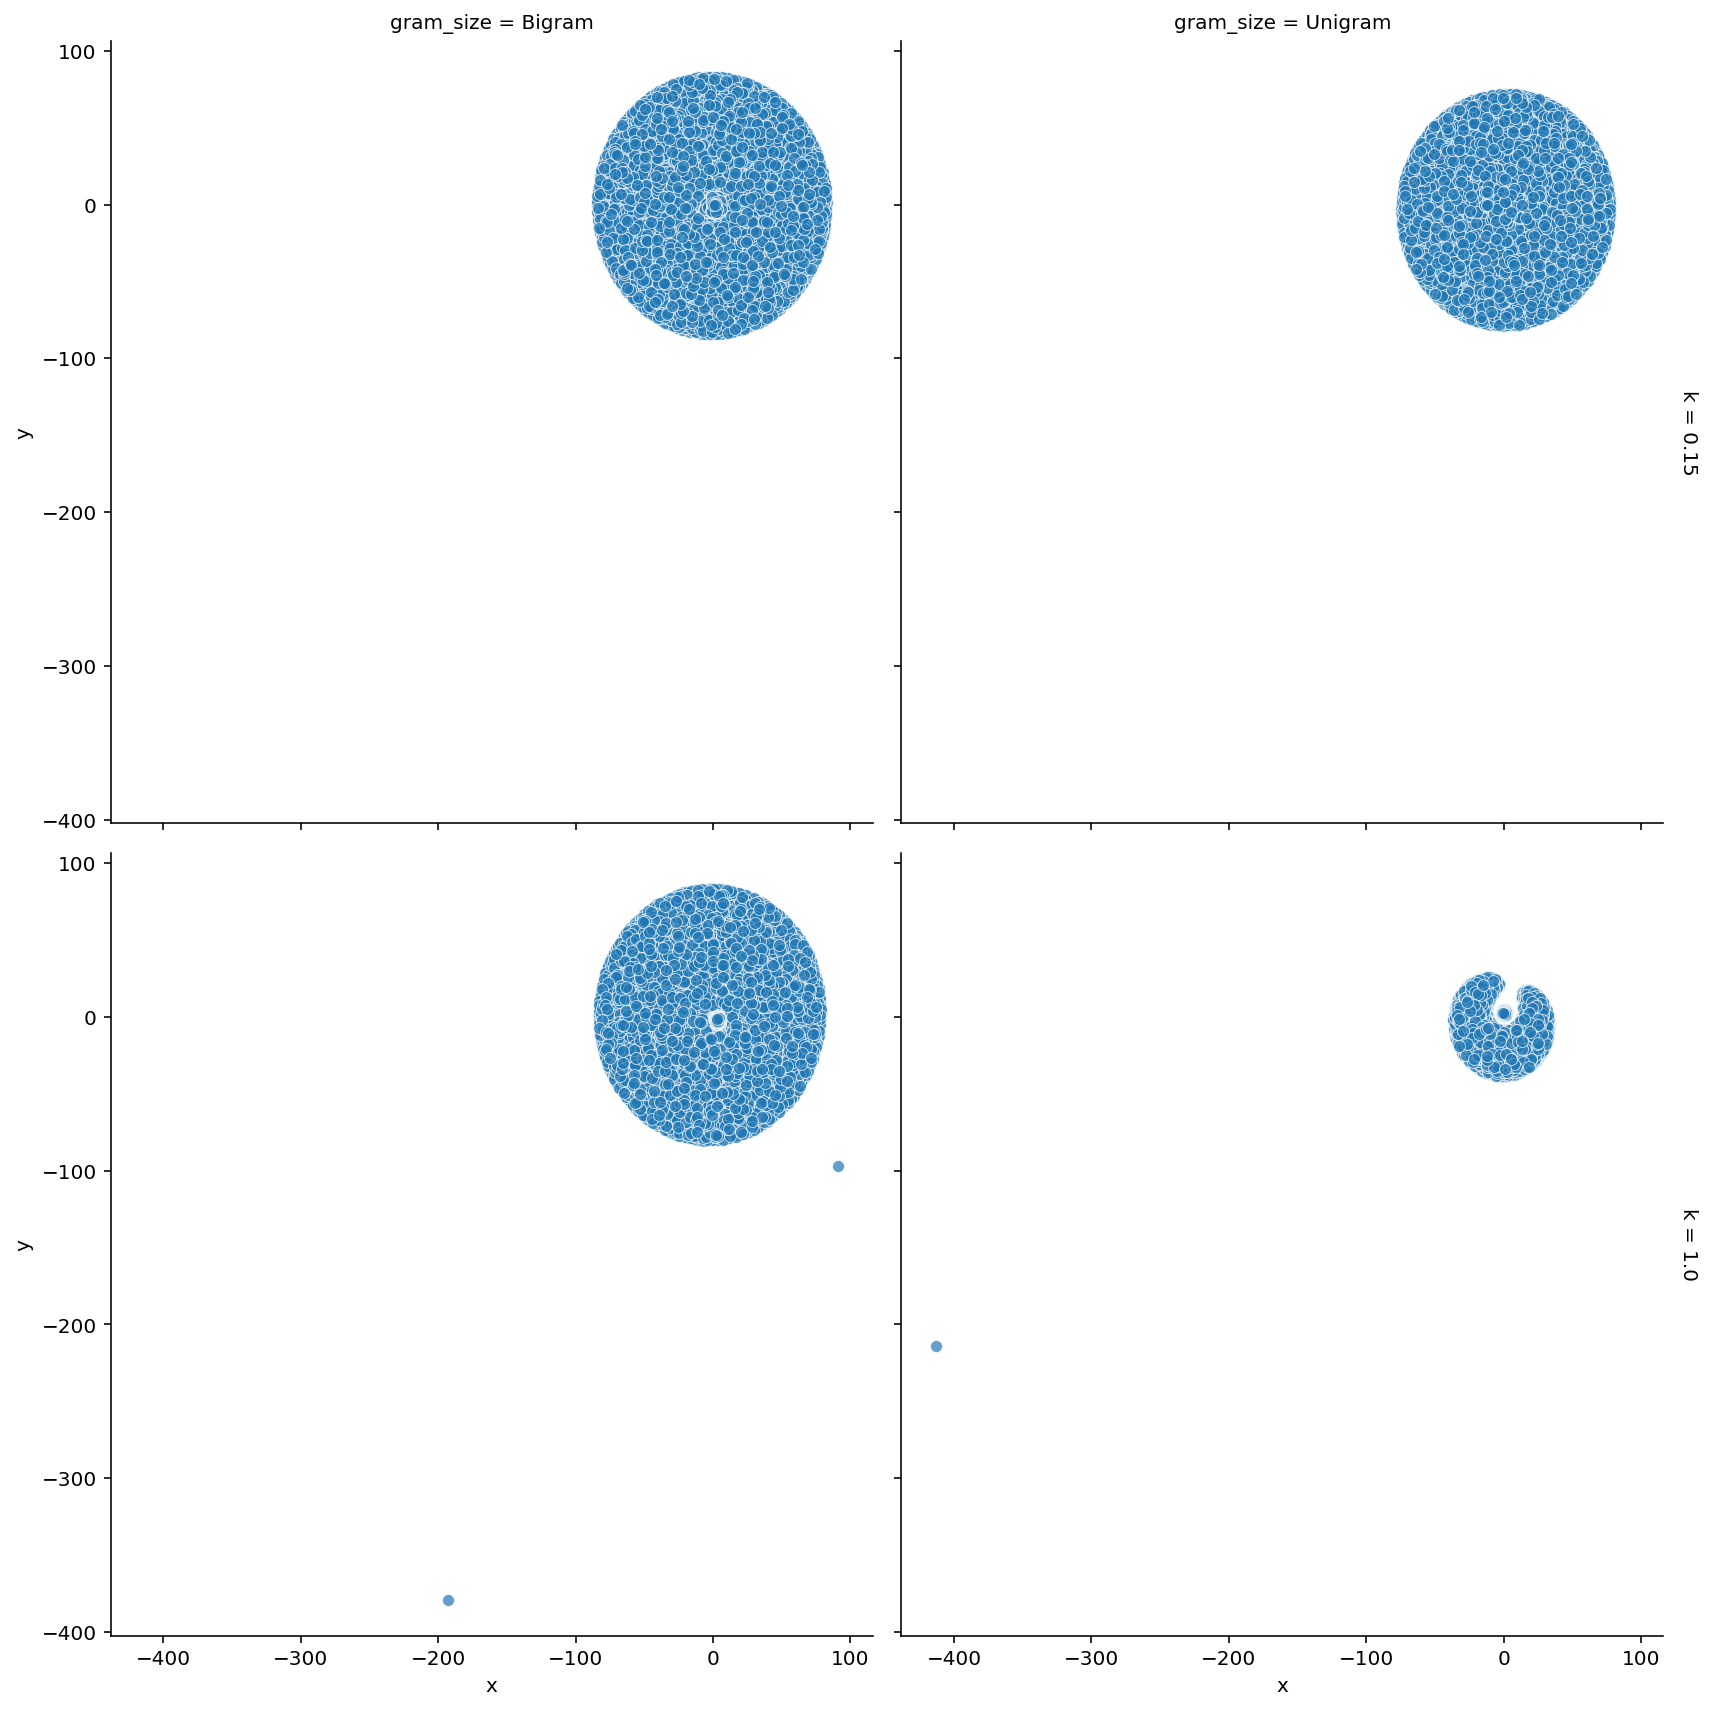

In [33]:
def color_graph(model_data, plot_title = ""):
    grid = sns.FacetGrid(model_data, col = 'gram_size',\
                        row = 'k', margin_titles=True,\
                        height=6, aspect=1)
    grid.map(sns.scatterplot, "x","y", legend="full" , alpha=0.7)

    #print(model_data['predict'].value_counts())
    return 
#print(model_data['x'])
color_graph(model_data, "EDA TSNE Results")

## TSNE Results

TSNE using both unigrams and bigrams seems to have the same results.  A ring with some spread data and a very tight core.  Just looking at some random results from each category, the groupings might be a division of hate speech vs offensive language.

## Initial Algorithim
I chose to use the data that had undergone T-SNE to try and get a result.  I found that just paring down the data to 2 columns with bigrams I can create a model with a  70% precision.  This algorithim ignores the Also, although I didn't implement a fix action, the 34% for unigrams is likely just mis-assigned variables and could be higher.  I'll do a more comprehensive solution when I 


In [34]:
def makeScores(d1, d2, text):
    print(text + ":  Raw Precision: " + str(precision_score(d1, d2, average = 'micro')) + \
          ", Weighted Precision: " + str(precision_score(d1, d2, average = 'weighted')) + \
         ", Weighted Recall: " + str(recall_score(d1, d2, average = 'weighted')) +\
         ", Weghted F1: " + str(f1_score(d1, d2, average = 'weighted')))
for ms in model_size:
    for k_val in k_values:
        makeScores(model_data[(model_data['gram_size'] == ms)\
                              & (model_data['k'] == k_val)]['predict'],\
                   raw_data['class'], str(ms) + " k = " + str(k_val))

Unigram k = 1:  Raw Precision: 0.3468506637614494, Weighted Precision: 0.4600580697560618, Weighted Recall: 0.3468506637614494, Weghted F1: 0.28772181887264403
Unigram k = 0.15:  Raw Precision: 0.5905257636282936, Weighted Precision: 0.6219508162159012, Weighted Recall: 0.5905257636282936, Weghted F1: 0.5951570682284234
Bigram k = 1:  Raw Precision: 0.6984626558528023, Weighted Precision: 0.8228880378798573, Weighted Recall: 0.6984626558528023, Weghted F1: 0.7555154598689697
Bigram k = 0.15:  Raw Precision: 0.6794173425331881, Weighted Precision: 0.7797318755050101, Weighted Recall: 0.6794173425331881, Weghted F1: 0.7257106744396595


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined 

## Model Building

I'm going to start with a DBSCAN model.  This is a popular model for text categorization and with the large doughnut hole in the middle of the data, I'm going to see if I can get the 2 blocks of data and test the results.

### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN or Density-Based Spatial Clustering of Applications with Noise is a clustering algorithm that uses the density of data points to classify objects.  DBSCAN only has 2 values that can be tuned.  The EPS or distance to look to find groupings of points, and the K_Value or number of points to be considered a grouping.  Conveniently, DBSCAN can be used to predict new points as well.

### Principal Component Analasys (PCA)
PCA is a dimmensional reduction algorithim that is used to shrink very wide data to narrower data.  This will be used to shrink the data and find patterns and manage the size of the model.
